# Simplified Centralized Federated Learning Analysis

This notebook analyzes the simplified metrics from centralized federated learning experiments:
- Global model metrics (accuracy, loss, gradient norm, gradient change)
- Per-client metrics (accuracy, loss, gradient norm, gradient change)
- Per-class metrics for both global and clients

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

Load the simplified centralized metrics from the latest experiment.

In [26]:
# Find the latest centralized experiment
logs_dir = Path('logs/centralized_fedavg')

# Get all experiment directories sorted by modification time (latest first)
experiment_dirs = sorted(
    [p for p in logs_dir.glob('*') if p.is_dir()],
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if not experiment_dirs:
    raise ValueError("No centralized experiments found in logs/centralized")

# Use the latest experiment
experiment_dir = experiment_dirs[0]
print(f"Loading data from: {experiment_dir}")

# Load the four simplified CSV files
global_metrics = pd.read_csv(experiment_dir / 'centralized_global_metrics.csv')
global_per_class = pd.read_csv(experiment_dir / 'centralized_global_per_class_metrics.csv')
client_metrics = pd.read_csv(experiment_dir / 'centralized_client_metrics.csv')
client_per_class = pd.read_csv(experiment_dir / 'centralized_client_per_class_metrics.csv')

print(f"\nLoaded {len(global_metrics)} global metric records")
print(f"Loaded {len(global_per_class)} global per-class metric records")
print(f"Loaded {len(client_metrics)} client metric records")
print(f"Loaded {len(client_per_class)} client per-class metric records")

# Display summary
print(f"\nNumber of rounds: {global_metrics['round'].max()}")
print(f"Number of clients: {client_metrics['client_id'].nunique()}")
print(f"Number of classes: {global_per_class['class_id'].nunique()}")

Loading data from: logs\centralized_fedavg\2026-02-06_23-52-39



Loaded 300 global metric records
Loaded 3000 global per-class metric records
Loaded 12000 client metric records
Loaded 120000 client per-class metric records

Number of rounds: 300
Number of clients: 40
Number of classes: 10


## 2. Global Model Accuracy

Track how the global model's accuracy evolves over rounds.

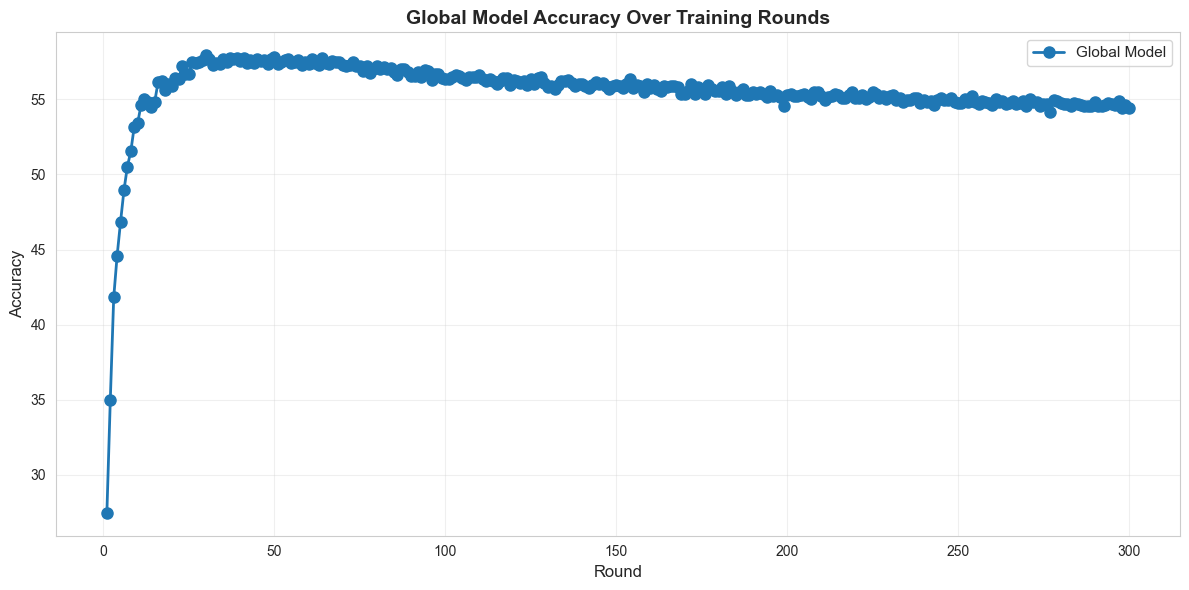

Final global accuracy: 54.4500
Best global accuracy: 57.9300 (round 30)
Average global accuracy: 55.5508


In [27]:
plt.figure(figsize=(12, 6))
plt.plot(global_metrics['round'], global_metrics['test_accuracy'], 
         marker='o', linewidth=2, markersize=8, label='Global Model')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Global Model Accuracy Over Training Rounds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Final global accuracy: {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"Best global accuracy: {global_metrics['test_accuracy'].max():.4f} (round {global_metrics.loc[global_metrics['test_accuracy'].idxmax(), 'round']})")
print(f"Average global accuracy: {global_metrics['test_accuracy'].mean():.4f}")

## 2b. Train vs Test Accuracy & Loss

Compare training metrics against test metrics to visualize the generalization gap.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Train vs Test Accuracy (Global)
if 'train_accuracy' in global_metrics.columns:
    axes[0].plot(global_metrics['round'], global_metrics['train_accuracy'],
                 marker='^', linewidth=2, markersize=6, label='Train Accuracy', linestyle='--', alpha=0.7)
axes[0].plot(global_metrics['round'], global_metrics['test_accuracy'],
             marker='o', linewidth=2, markersize=6, label='Test Accuracy')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Global Model: Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right: Train vs Test Loss (Global)
if 'train_loss' in global_metrics.columns:
    axes[1].plot(global_metrics['round'], global_metrics['train_loss'],
                 marker='^', linewidth=2, markersize=6, label='Train Loss', linestyle='--', alpha=0.7, color='orange')
axes[1].plot(global_metrics['round'], global_metrics['test_loss'],
             marker='s', linewidth=2, markersize=6, label='Test Loss', color='red')
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Global Model: Train vs Test Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print generalization gap
if 'train_accuracy' in global_metrics.columns:
    final = global_metrics.iloc[-1]
    print(f"Final Round Generalization Gap:")
    print(f"  Train Accuracy: {final['train_accuracy']:.4f}")
    print(f"  Test Accuracy:  {final['test_accuracy']:.4f}")
    print(f"  Gap: {final['train_accuracy'] - final['test_accuracy']:.4f}")
    print(f"\n  Train Loss: {final['train_loss']:.4f}")
    print(f"  Test Loss:  {final['test_loss']:.4f}")
    print(f"  Gap: {final['test_loss'] - final['train_loss']:.4f}")
else:
    print("Note: train_accuracy/train_loss columns not found. Re-run experiments with updated code.")

## 3. Global Model Loss

Track the global model's loss over rounds.

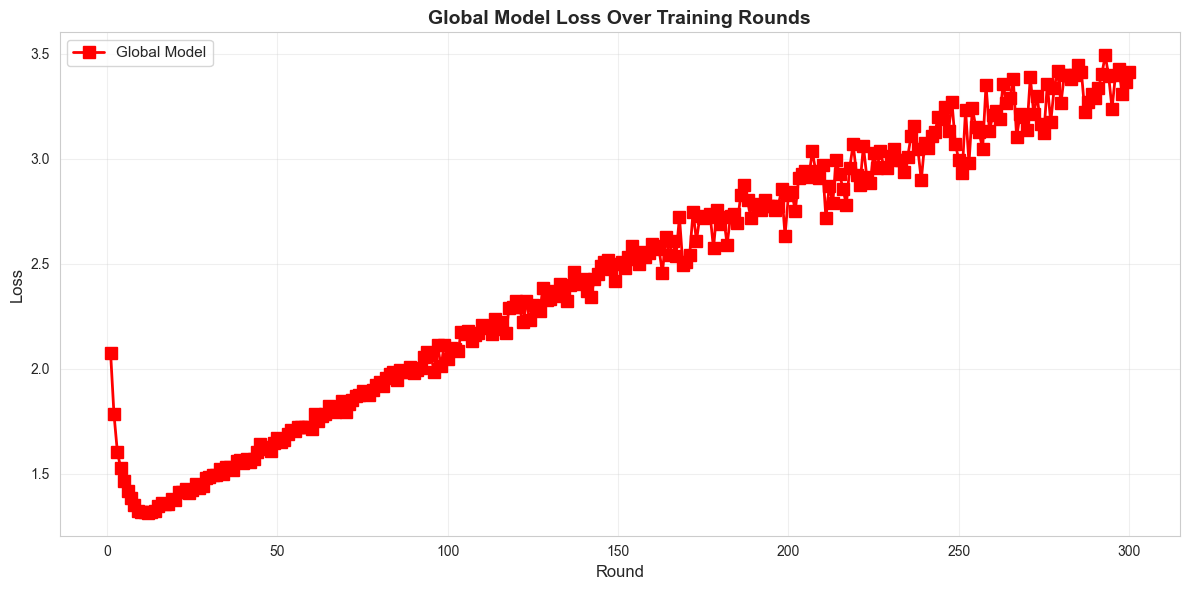

Final global loss: 3.4139
Best (lowest) global loss: 1.3130 (round 12)
Average global loss: 2.4323


In [28]:
plt.figure(figsize=(12, 6))
plt.plot(global_metrics['round'], global_metrics['test_loss'], 
         marker='s', linewidth=2, markersize=8, label='Global Model', color='red')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Global Model Loss Over Training Rounds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Final global loss: {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"Best (lowest) global loss: {global_metrics['test_loss'].min():.4f} (round {global_metrics.loc[global_metrics['test_loss'].idxmin(), 'round']})")
print(f"Average global loss: {global_metrics['test_loss'].mean():.4f}")

## 4. Global Model Gradient Metrics

Track gradient norm and gradient change for the global model.

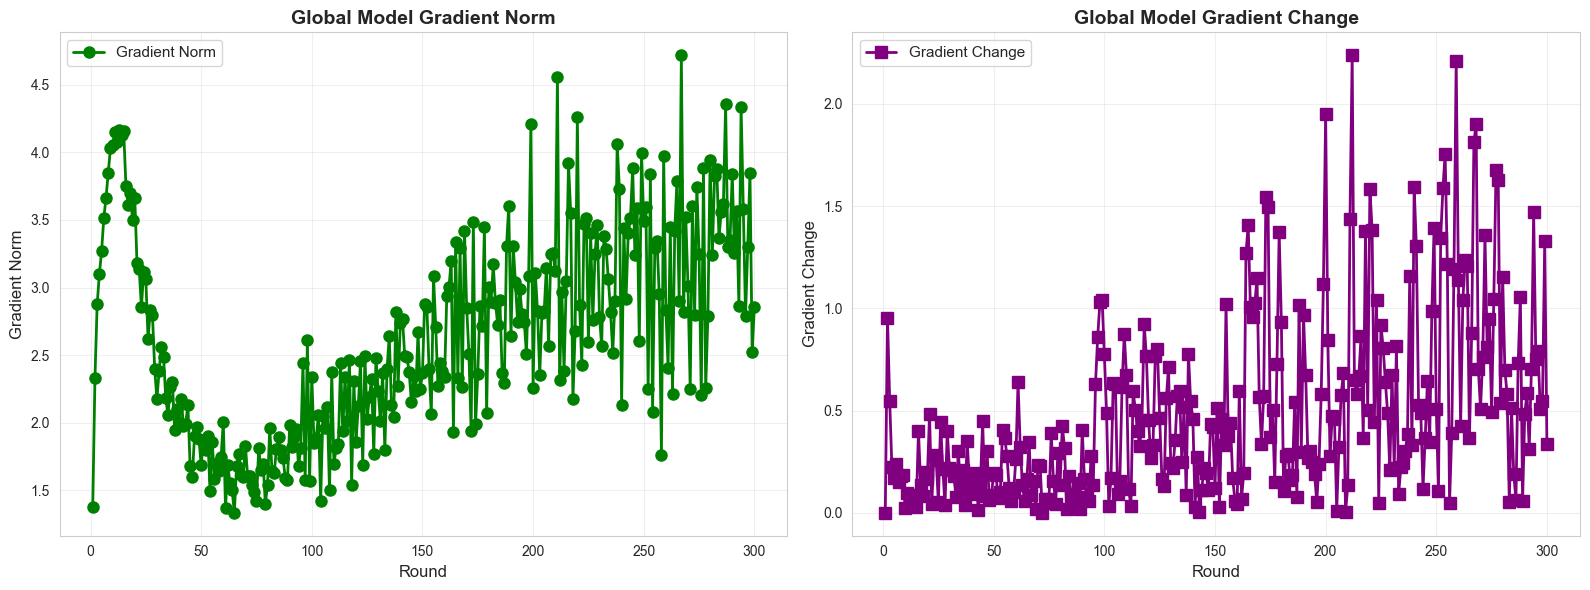

Final gradient norm: 2.8577
Average gradient norm: 2.6428
Final gradient change: 0.3367
Average gradient change: 0.4904


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gradient Norm
axes[0].plot(global_metrics['round'], global_metrics['gradient_norm'], 
             marker='o', linewidth=2, markersize=8, label='Gradient Norm', color='green')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Gradient Norm', fontsize=12)
axes[0].set_title('Global Model Gradient Norm', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Gradient Change (skip first round since it has no previous to compare to)
gradient_change_data = global_metrics[global_metrics['round'] > 0]
axes[1].plot(gradient_change_data['round'], gradient_change_data['gradient_change'], 
             marker='s', linewidth=2, markersize=8, label='Gradient Change', color='purple')
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Gradient Change', fontsize=12)
axes[1].set_title('Global Model Gradient Change', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final gradient norm: {global_metrics['gradient_norm'].iloc[-1]:.4f}")
print(f"Average gradient norm: {global_metrics['gradient_norm'].mean():.4f}")
if len(gradient_change_data) > 0:
    print(f"Final gradient change: {gradient_change_data['gradient_change'].iloc[-1]:.4f}")
    print(f"Average gradient change: {gradient_change_data['gradient_change'].mean():.4f}")

## 5. Per-Client Accuracy Comparison

Compare accuracy across all clients over rounds.

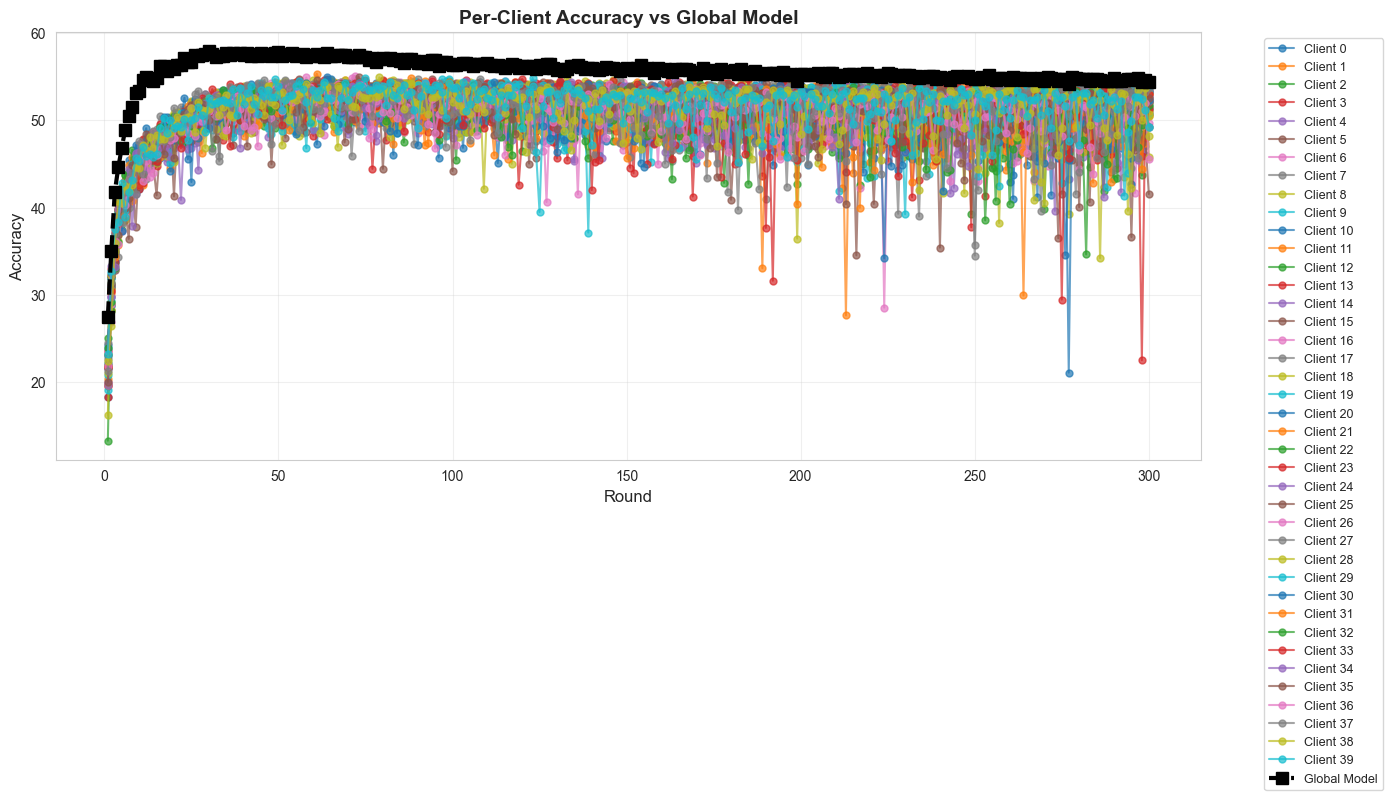


Final accuracies per client:
  Client 0.0: 52.8000
  Client 1.0: 50.5100
  Client 2.0: 52.5200
  Client 3.0: 50.6800
  Client 4.0: 52.4500
  Client 5.0: 52.1200
  Client 6.0: 49.6700
  Client 7.0: 51.1600
  Client 8.0: 50.4900
  Client 9.0: 50.8700
  Client 10.0: 51.3200
  Client 11.0: 51.0900
  Client 12.0: 51.6100
  Client 13.0: 51.4700
  Client 14.0: 52.2600
  Client 15.0: 41.5600
  Client 16.0: 52.9600
  Client 17.0: 53.4100
  Client 18.0: 50.7300
  Client 19.0: 53.7100
  Client 20.0: 53.2800
  Client 21.0: 53.1300
  Client 22.0: 51.7600
  Client 23.0: 53.3600
  Client 24.0: 53.2600
  Client 25.0: 52.0700
  Client 26.0: 52.5100
  Client 27.0: 52.1700
  Client 28.0: 45.7900
  Client 29.0: 53.3000
  Client 30.0: 52.3600
  Client 31.0: 53.0100
  Client 32.0: 49.2700
  Client 33.0: 52.9900
  Client 34.0: 49.2400
  Client 35.0: 52.5800
  Client 36.0: 45.5400
  Client 37.0: 53.7200
  Client 38.0: 48.2500
  Client 39.0: 49.2900

Global Model: 54.4500

Average client accuracy: 51.2567
Std

In [30]:
plt.figure(figsize=(14, 7))

# Plot each client's accuracy
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    plt.plot(client_data['round'], client_data['test_accuracy'], 
             marker='o', linewidth=1.5, markersize=5, label=f'Client {client_id}', alpha=0.7)

# Also plot global model for comparison
plt.plot(global_metrics['round'], global_metrics['test_accuracy'], 
         marker='s', linewidth=3, markersize=8, label='Global Model', color='black', linestyle='--')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Client Accuracy vs Global Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# Print final accuracies
print("\nFinal accuracies per client:")
final_round = client_metrics['round'].max()
final_client_accuracies = client_metrics[client_metrics['round'] == final_round].sort_values('client_id')
for _, row in final_client_accuracies.iterrows():
    print(f"  Client {row['client_id']}: {row['test_accuracy']:.4f}")
print(f"\nGlobal Model: {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"\nAverage client accuracy: {final_client_accuracies['test_accuracy'].mean():.4f}")
print(f"Std dev: {final_client_accuracies['test_accuracy'].std():.4f}")

## 6. Per-Client Loss Comparison

Compare loss across all clients over rounds.

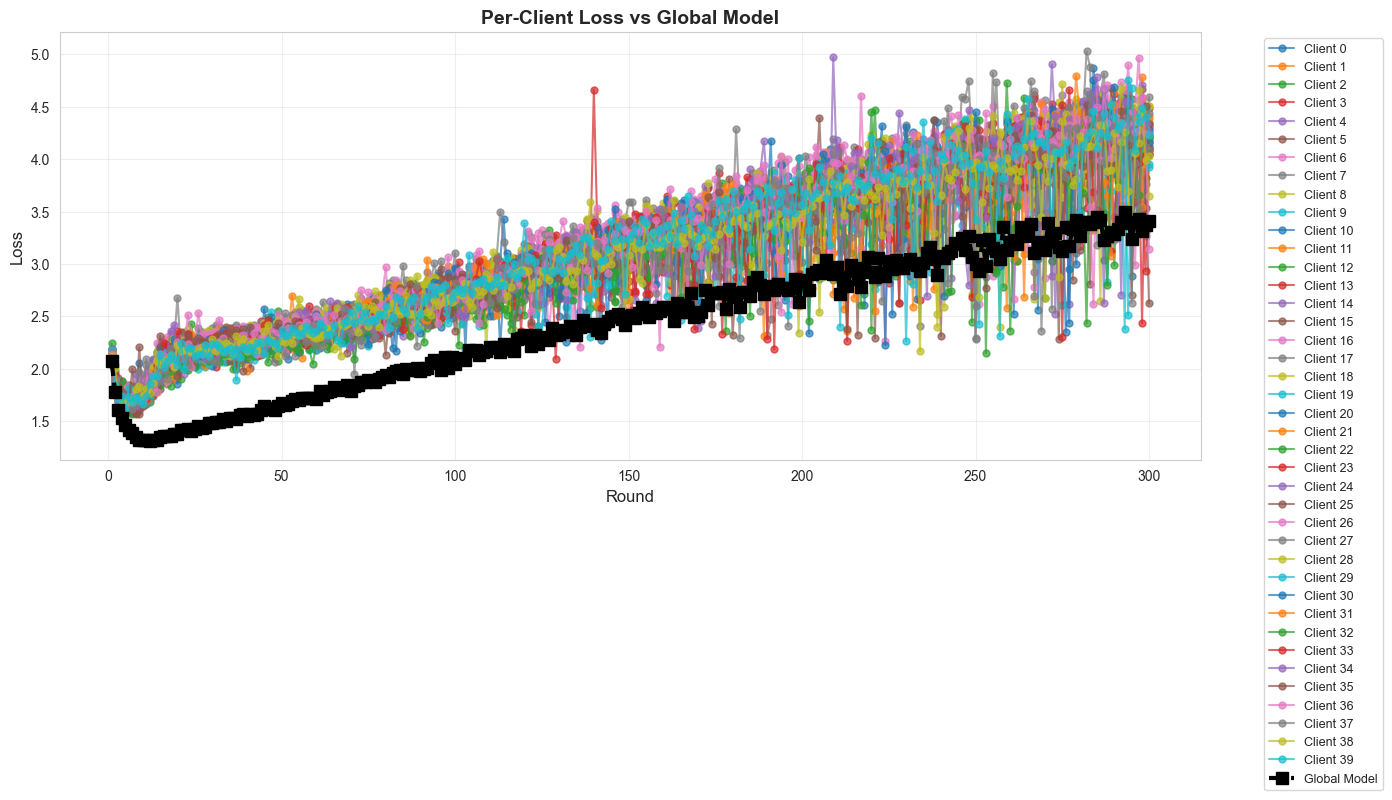


Final losses per client:
  Client 0.0: 4.3431
  Client 1.0: 4.3831
  Client 2.0: 4.3130
  Client 3.0: 4.4885
  Client 4.0: 4.1157
  Client 5.0: 4.2132
  Client 6.0: 4.2318
  Client 7.0: 4.5894
  Client 8.0: 4.5060
  Client 9.0: 4.0988
  Client 10.0: 4.2293
  Client 11.0: 4.4104
  Client 12.0: 4.1879
  Client 13.0: 4.2937
  Client 14.0: 4.1222
  Client 15.0: 2.6228
  Client 16.0: 4.3229
  Client 17.0: 4.0850
  Client 18.0: 4.5043
  Client 19.0: 3.9502
  Client 20.0: 4.2789
  Client 21.0: 4.0630
  Client 22.0: 4.1544
  Client 23.0: 4.0500
  Client 24.0: 4.0980
  Client 25.0: 4.3326
  Client 26.0: 4.1770
  Client 27.0: 4.4361
  Client 28.0: 3.6462
  Client 29.0: 3.9220
  Client 30.0: 4.1648
  Client 31.0: 4.2404
  Client 32.0: 4.2112
  Client 33.0: 4.0931
  Client 34.0: 4.2579
  Client 35.0: 4.0373
  Client 36.0: 3.1422
  Client 37.0: 4.0914
  Client 38.0: 4.0277
  Client 39.0: 4.2318

Global Model: 3.4139

Average client loss: 4.1417
Std dev: 0.3483


In [31]:
plt.figure(figsize=(14, 7))

# Plot each client's loss
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    plt.plot(client_data['round'], client_data['test_loss'], 
             marker='o', linewidth=1.5, markersize=5, label=f'Client {client_id}', alpha=0.7)

# Also plot global model for comparison
plt.plot(global_metrics['round'], global_metrics['test_loss'], 
         marker='s', linewidth=3, markersize=8, label='Global Model', color='black', linestyle='--')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Per-Client Loss vs Global Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# Print final losses
print("\nFinal losses per client:")
final_round = client_metrics['round'].max()
final_client_losses = client_metrics[client_metrics['round'] == final_round].sort_values('client_id')
for _, row in final_client_losses.iterrows():
    print(f"  Client {row['client_id']}: {row['test_loss']:.4f}")
print(f"\nGlobal Model: {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"\nAverage client loss: {final_client_losses['test_loss'].mean():.4f}")
print(f"Std dev: {final_client_losses['test_loss'].std():.4f}")

## 7. Per-Client Gradient Metrics

Analyze gradient norms and changes across clients.

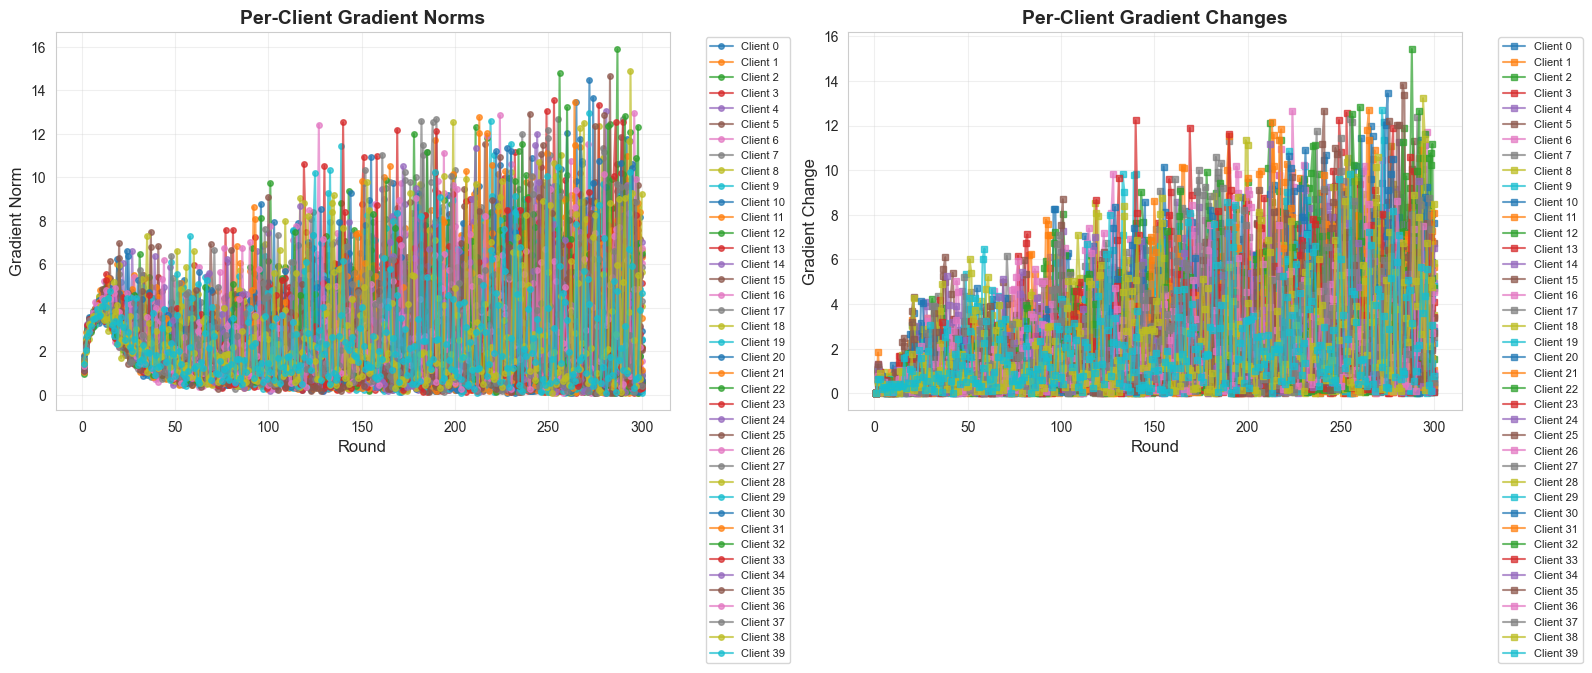


Final gradient norms per client:
  Client 0.0: 2.5395
  Client 1.0: 3.5505
  Client 2.0: 0.9036
  Client 3.0: 5.1639
  Client 4.0: 1.0556
  Client 5.0: 0.4319
  Client 6.0: 6.0473
  Client 7.0: 5.8831
  Client 8.0: 5.6579
  Client 9.0: 2.5684
  Client 10.0: 2.9222
  Client 11.0: 6.3547
  Client 12.0: 2.2111
  Client 13.0: 2.1648
  Client 14.0: 0.2174
  Client 15.0: 6.4123
  Client 16.0: 1.5595
  Client 17.0: 0.5988
  Client 18.0: 4.0751
  Client 19.0: 0.0875
  Client 20.0: 0.5392
  Client 21.0: 0.3441
  Client 22.0: 0.5990
  Client 23.0: 0.6748
  Client 24.0: 0.8770
  Client 25.0: 2.0721
  Client 26.0: 0.4018
  Client 27.0: 4.2988
  Client 28.0: 6.6476
  Client 29.0: 0.2203
  Client 30.0: 0.6902
  Client 31.0: 1.1516
  Client 32.0: 6.5093
  Client 33.0: 0.3147
  Client 34.0: 7.0441
  Client 35.0: 0.4581
  Client 36.0: 6.7363
  Client 37.0: 0.3984
  Client 38.0: 9.2468
  Client 39.0: 4.6773

Average gradient norm: 2.8577
Std dev: 2.6127


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gradient Norm
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    axes[0].plot(client_data['round'], client_data['gradient_norm'], 
                 marker='o', linewidth=1.5, markersize=4, label=f'Client {client_id}', alpha=0.7)

axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Gradient Norm', fontsize=12)
axes[0].set_title('Per-Client Gradient Norms', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Gradient Change (skip first round)
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[(client_metrics['client_id'] == client_id) & (client_metrics['round'] > 0)]
    axes[1].plot(client_data['round'], client_data['gradient_change'], 
                 marker='s', linewidth=1.5, markersize=4, label=f'Client {client_id}', alpha=0.7)

axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Gradient Change', fontsize=12)
axes[1].set_title('Per-Client Gradient Changes', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Print statistics
final_round = client_metrics['round'].max()
final_gradient_norms = client_metrics[client_metrics['round'] == final_round]
print(f"\nFinal gradient norms per client:")
for _, row in final_gradient_norms.sort_values('client_id').iterrows():
    print(f"  Client {row['client_id']}: {row['gradient_norm']:.4f}")
print(f"\nAverage gradient norm: {final_gradient_norms['gradient_norm'].mean():.4f}")
print(f"Std dev: {final_gradient_norms['gradient_norm'].std():.4f}")

## 8. Global Per-Class Accuracy

Show how the global model performs on each class.

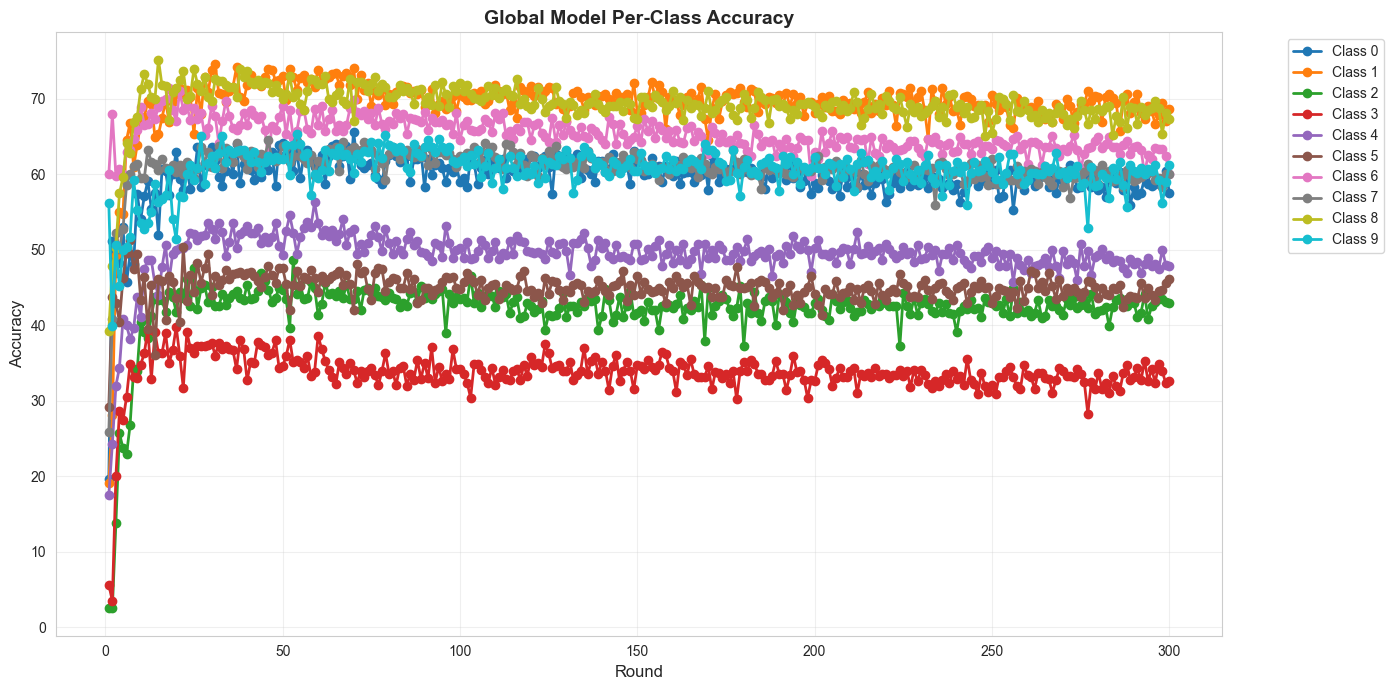


Final global model per-class accuracies:
  Class 0.0: 57.5000 (loss: 0.0000)
  Class 1.0: 68.7000 (loss: 0.0000)
  Class 2.0: 42.9000 (loss: 0.0000)
  Class 3.0: 32.6000 (loss: 0.0000)
  Class 4.0: 47.8000 (loss: 0.0000)
  Class 5.0: 46.2000 (loss: 0.0000)
  Class 6.0: 60.0000 (loss: 0.0000)
  Class 7.0: 60.1000 (loss: 0.0000)
  Class 8.0: 67.4000 (loss: 0.0000)
  Class 9.0: 61.3000 (loss: 0.0000)

Average per-class accuracy: 54.4500
Std dev: 11.6085


In [33]:
plt.figure(figsize=(14, 7))

# Plot each class's accuracy
for class_id in sorted(global_per_class['class_id'].unique()):
    class_data = global_per_class[global_per_class['class_id'] == class_id]
    plt.plot(class_data['round'], class_data['class_accuracy'], 
             marker='o', linewidth=2, markersize=6, label=f'Class {class_id}')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Global Model Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Print final per-class accuracies
print("\nFinal global model per-class accuracies:")
final_round = global_per_class['round'].max()
final_class_accuracies = global_per_class[global_per_class['round'] == final_round].sort_values('class_id')
for _, row in final_class_accuracies.iterrows():
    print(f"  Class {row['class_id']}: {row['class_accuracy']:.4f} (loss: {row['class_loss']:.4f})")
print(f"\nAverage per-class accuracy: {final_class_accuracies['class_accuracy'].mean():.4f}")
print(f"Std dev: {final_class_accuracies['class_accuracy'].std():.4f}")

## 9. Client Per-Class Accuracy Comparison

Compare how different clients perform on each class (final round only for clarity).

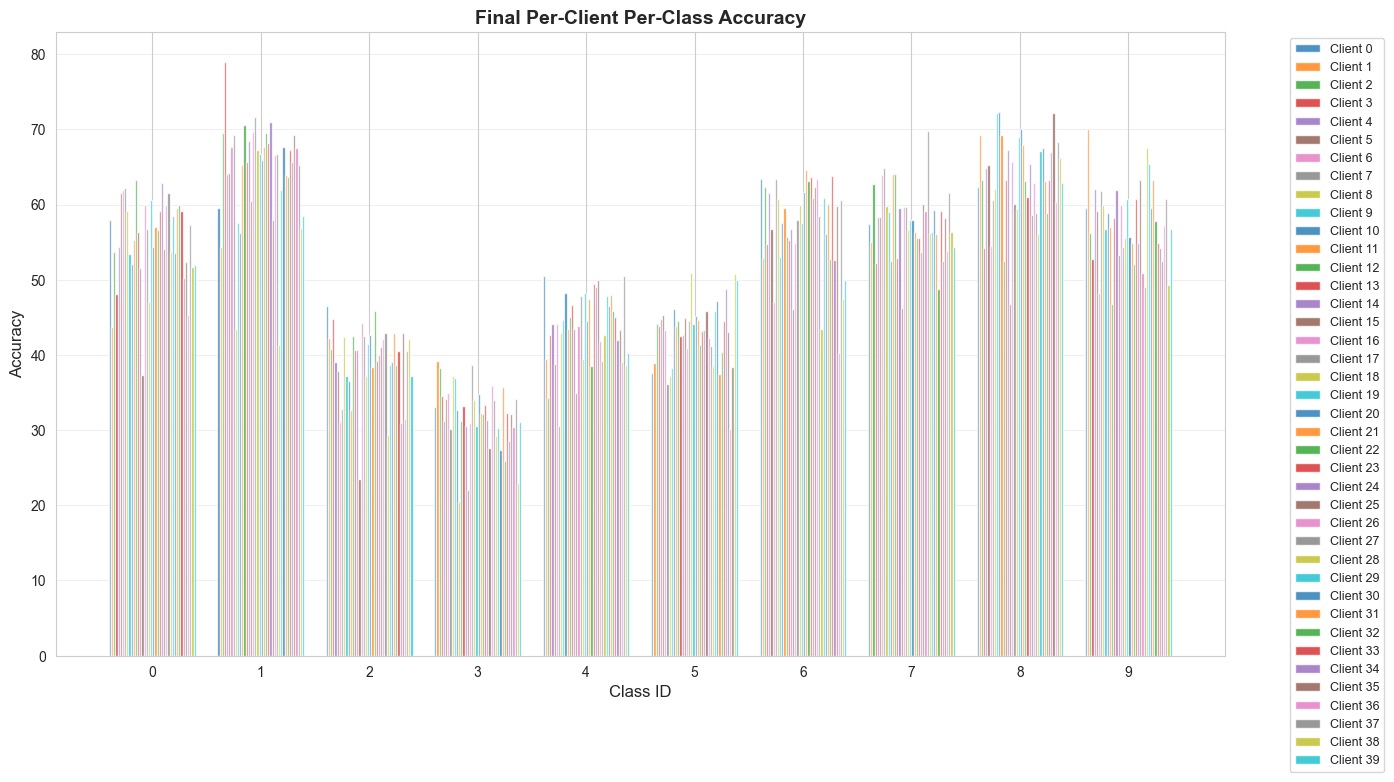


Per-class statistics across clients:
  Class 0: mean=55.3800, std=5.6710, min=37.3000, max=63.3000
  Class 1: mean=64.3175, std=7.0703, min=41.3000, max=79.0000
  Class 2: mean=39.0725, std=4.8734, min=23.5000, max=46.5000
  Class 3: mean=31.8825, std=4.1970, min=20.5000, max=39.2000
  Class 4: mean=43.5725, std=4.6546, min=30.5000, max=50.5000
  Class 5: mean=42.9025, std=4.1828, min=30.2000, max=50.9000
  Class 6: mean=57.0850, std=6.0022, min=40.3000, max=64.6000
  Class 7: mean=57.6425, std=4.4571, min=46.3000, max=69.8000
  Class 8: mean=63.3675, std=5.6201, min=46.8000, max=72.3000
  Class 9: mean=57.3450, std=5.1406, min=46.8000, max=70.0000


In [34]:
# Get final round data
final_round = client_per_class['round'].max()
final_data = client_per_class[client_per_class['round'] == final_round]

# Create a pivot table for easier plotting
pivot_accuracy = final_data.pivot(index='class_id', columns='client_id', values='class_accuracy')

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(pivot_accuracy.index))
width = 0.8 / len(pivot_accuracy.columns)

for i, client_id in enumerate(sorted(pivot_accuracy.columns)):
    offset = width * i - (0.8 - width) / 2
    ax.bar(x + offset, pivot_accuracy[client_id], width, label=f'Client {client_id}', alpha=0.8)

ax.set_xlabel('Class ID', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Final Per-Client Per-Class Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_accuracy.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print statistics per class
print("\nPer-class statistics across clients:")
for class_id in sorted(pivot_accuracy.index):
    class_accuracies = pivot_accuracy.loc[class_id]
    print(f"  Class {class_id}: mean={class_accuracies.mean():.4f}, std={class_accuracies.std():.4f}, "
          f"min={class_accuracies.min():.4f}, max={class_accuracies.max():.4f}")

## 10. Summary Statistics

Overall summary of the centralized training experiment.

In [35]:
print("="*60)
print("CENTRALIZED FEDERATED LEARNING - SUMMARY STATISTICS")
print("="*60)

print("\n📊 GLOBAL MODEL PERFORMANCE")
print("-" * 60)
print(f"Final Accuracy:        {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"Best Accuracy:         {global_metrics['test_accuracy'].max():.4f} (Round {global_metrics.loc[global_metrics['test_accuracy'].idxmax(), 'round']})")
print(f"Final Loss:            {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"Best Loss:             {global_metrics['test_loss'].min():.4f} (Round {global_metrics.loc[global_metrics['test_loss'].idxmin(), 'round']})")
print(f"Final Gradient Norm:   {global_metrics['gradient_norm'].iloc[-1]:.4f}")

print("\n👥 CLIENT PERFORMANCE")
print("-" * 60)
final_round = client_metrics['round'].max()
final_clients = client_metrics[client_metrics['round'] == final_round]
print(f"Number of Clients:     {len(final_clients)}")
print(f"Avg Client Accuracy:   {final_clients['test_accuracy'].mean():.4f} ± {final_clients['test_accuracy'].std():.4f}")
print(f"Best Client:           {final_clients.loc[final_clients['test_accuracy'].idxmax(), 'client_id']} "
      f"({final_clients['test_accuracy'].max():.4f})")
print(f"Worst Client:          {final_clients.loc[final_clients['test_accuracy'].idxmin(), 'client_id']} "
      f"({final_clients['test_accuracy'].min():.4f})")
print(f"Avg Client Loss:       {final_clients['test_loss'].mean():.4f} ± {final_clients['test_loss'].std():.4f}")

print("\n🎯 PER-CLASS PERFORMANCE (GLOBAL MODEL)")
print("-" * 60)
final_classes = global_per_class[global_per_class['round'] == final_round]
print(f"Number of Classes:     {len(final_classes)}")
print(f"Avg Class Accuracy:    {final_classes['class_accuracy'].mean():.4f} ± {final_classes['class_accuracy'].std():.4f}")
print(f"Best Class:            {final_classes.loc[final_classes['class_accuracy'].idxmax(), 'class_id']} "
      f"({final_classes['class_accuracy'].max():.4f})")
print(f"Worst Class:           {final_classes.loc[final_classes['class_accuracy'].idxmin(), 'class_id']} "
      f"({final_classes['class_accuracy'].min():.4f})")

print("\n📈 TRAINING DYNAMICS")
print("-" * 60)
print(f"Total Rounds:          {len(global_metrics)}")
accuracy_improvement = global_metrics['test_accuracy'].iloc[-1] - global_metrics['test_accuracy'].iloc[0]
loss_improvement = global_metrics['test_loss'].iloc[0] - global_metrics['test_loss'].iloc[-1]
print(f"Accuracy Improvement:  {accuracy_improvement:+.4f} ({accuracy_improvement/global_metrics['test_accuracy'].iloc[0]*100:+.2f}%)")
print(f"Loss Improvement:      {loss_improvement:+.4f} ({loss_improvement/global_metrics['test_loss'].iloc[0]*100:+.2f}%)")

# Calculate convergence indicator (gradient stabilization)
if len(global_metrics) > 5:
    recent_gradient_std = global_metrics['gradient_norm'].iloc[-5:].std()
    print(f"Recent Gradient Std:   {recent_gradient_std:.4f} (convergence indicator)")

print("\n" + "="*60)
print(f"Experiment: {experiment_dir.name}")
print(f"Location: {experiment_dir}")
print("="*60)

CENTRALIZED FEDERATED LEARNING - SUMMARY STATISTICS

📊 GLOBAL MODEL PERFORMANCE
------------------------------------------------------------
Final Accuracy:        54.4500
Best Accuracy:         57.9300 (Round 30)
Final Loss:            3.4139
Best Loss:             1.3130 (Round 12)
Final Gradient Norm:   2.8577

👥 CLIENT PERFORMANCE
------------------------------------------------------------
Number of Clients:     40
Avg Client Accuracy:   51.2567 ± 2.4885
Best Client:           37 (53.7200)
Worst Client:          15 (41.5600)
Avg Client Loss:       4.1417 ± 0.3483

🎯 PER-CLASS PERFORMANCE (GLOBAL MODEL)
------------------------------------------------------------
Number of Classes:     10
Avg Class Accuracy:    54.4500 ± 11.6085
Best Class:            1 (68.7000)
Worst Class:           3 (32.6000)

📈 TRAINING DYNAMICS
------------------------------------------------------------
Total Rounds:          300
Accuracy Improvement:  +26.9700 (+98.14%)
Loss Improvement:      -1.3372 (-64.